Code for Parts 1 and 2: Strategy Replication and Family of Strategies

In [1]:
#Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import Data - this cell takes around 22 seconds to run, so further formatting is done below to save runtime
contdf = pd.read_excel(
    "v2_contrarian_data.xlsx",
    header = 0,
    usecols = ["d", "id", "r", "company"],
    parse_dates = ["d"]
)
contdf["r_simple"] = np.exp(contdf["r"]) - 1
print(contdf.isna().sum())
print(contdf.head(10))

d           0
id          0
r           0
company     0
r_simple    0
dtype: int64
           d     id         r                              company  r_simple
0 1992-01-02  10137  0.000000  ALLEGHENY ENERGY INC                 0.000000
1 1992-01-02  10225 -0.016800  BEAM INC                            -0.016660
2 1992-01-02  10401  0.003190  A T & T CORP                         0.003195
3 1992-01-02  10488  0.117783  AMERICAN LOCKER GROUP                0.125000
4 1992-01-02  10516 -0.038500  ARCHER DANIELS MIDLAND CO           -0.037768
5 1992-01-02  10656  0.031100  ACETO CORP                           0.031589
6 1992-01-02  10866  0.057400  CALERES INC                          0.059079
7 1992-01-02  10890  0.114410  UNISYS CORP                          0.121212
8 1992-01-02  11308  0.000000  COCA COLA CO                         0.000000
9 1992-01-02  11404 -0.008770  CONSOLIDATED EDISON INC             -0.008732


In [16]:
#Pivot the data wide so matrix arithmetic in contrarian strategy is easier
full_r_df = contdf.pivot(index = "d", columns = "id", values = "r_simple")
full_r_bar = full_r_df.mean(axis = 1) #equal weighted average return of N stocks in universe
full_n = full_r_df.count(axis = 1)
#TODO: n changes from 690 to 689 somewhere, want to find and observe anomaly

#Full Excess Returns DataFrame
full_r_excess_df = full_r_df.sub(full_r_bar, axis = 0) #excess returns
# print(r_excessdf.head(10))
# print(full_r_bar.head(10))
# print(full_n.head(10))

In [17]:
#OPTIONAL FOR TESTING: Truncate data to make it easier to work with during development and debugging before applying to whole dataset
stock_cols_small = np.random.choice(range(1, 690), size = 10, replace = False)
stock_cols_small.sort() #pick random cols for stocks - excluding the last stock column until we figure out TODO above
print(stock_cols_small)

small_r_df = full_r_df.iloc[:, stock_cols_small].copy()
print(small_r_df)

small_r_bar = small_r_df.mean(axis = 1)
small_n = small_r_df.count(axis = 1)

small_r_excess_df = small_r_df.sub(small_r_bar, axis = 0)
print(small_r_excess_df)
# print(small_r_bar)
# print(small_n)

[ 60  77 137 274 299 530 559 596 645 656]
id             15553     17478     22509     32379     36003     57534  \
d                                                                        
1992-01-02 -0.006827 -0.004360  0.004952  0.001091 -0.008732 -0.015577   
1992-01-03  0.000000 -0.004380  0.002463  0.013085 -0.004410  0.015824   
1992-01-06 -0.010346  0.006592  0.014707 -0.002158 -0.008851  0.015621   
1992-01-07  0.000000  0.013085  0.031486 -0.007561 -0.017839  0.123077   
1992-01-08  0.006944 -0.006469  0.014085  0.028293  0.009091 -0.013705   
...              ...       ...       ...       ...       ...       ...   
1997-12-24  0.021324 -0.000892 -0.001119 -0.016069 -0.018428  0.015824   
1997-12-26 -0.017937 -0.001788  0.002232  0.004460 -0.003125 -0.015577   
1997-12-29  0.006078  0.023267  0.010020  0.036331 -0.003135 -0.015873   
1997-12-30  0.009061  0.020099  0.032001  0.000000  0.028293 -0.092716   
1997-12-31 -0.020977  0.014606 -0.023519  0.022923 -0.009178  0.000000

In [18]:
#Helper Functions: Assembling the Contrarian Strategy

#Toggle between "small" and "full" to switch between smaller testing universe to overall universe - general parameters used for rest of code
run_return_df = full_r_df
run_excess_df = full_r_excess_df
run_mean_df = full_r_bar
run_n = full_n

#Function to normalize the weights dataframe
def normalize_weights(weight_df, separate_ls = False):
    '''
        Takes a dataframe of weights based on excess returns with k lags and normalizes the long and short weights to sum to 1
        Returns a normalized weight dataframe
    '''
    #Constraint 1: longs and shorts are balanced (weights sum to 0)
    # print(weight_df.sum(axis = 1).head(10))

    #Constraint 2: long/short portfolio is fully invested (long weights and short weights separately sum to 1)
    long_portfolio = weight_df.clip(lower = 0)
    # print(long_portfolio)
    short_portfolio = weight_df.clip(upper = 0)
    # print(short_portfolio)

    long_weights = long_portfolio.div(long_portfolio.sum(axis = 1), axis = 0)
    # print(long_weights.sum(axis = 1).head(10))
    short_weights = short_portfolio.div(short_portfolio.abs().sum(axis = 1), axis = 0)
    # print(short_weights.sum(axis = 1).head(10))

    norm_weight_df = long_weights + short_weights

    if separate_ls:
        return long_weights, short_weights
    
    return norm_weight_df

#Function to construct the contrarian strategy
def contrarian_strategy(return_df, excess_df, k, separate_ls = False):
    '''
        Takes dataframes of simple and excess returns and a lag variable k and constructs a contrarian strategy with weights
            based on the negative excess returns k days ago.
        Returns a dataframe of strategy profits per day
    '''
    weight_df = -(excess_df.shift(k - 1)).fillna(0)
    if separate_ls:
        long_weights, short_weights = normalize_weights(weight_df, separate_ls=separate_ls)

        #Find daily portfolio returns
        weight_1_lag = (long_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        long_profit = profit.iloc[k:]

        #Find daily portfolio returns
        weight_1_lag = (short_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        short_profit = profit.iloc[k:]
        return long_profit, short_profit
    else:
        norm_weight_df = normalize_weights(weight_df, separate_ls=separate_ls)

        #Data checks - ensure dates and columns are the same
        assert norm_weight_df.index.equals(return_df.index)
        assert norm_weight_df.columns.equals(return_df.columns)

        #Find daily portfolio returns
        weight_1_lag = (norm_weight_df.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        profit = profit.iloc[k:]
        return profit

Strategy Results: Annualized Mean: 3.7246682385335554, Annualized Vol: 0.1744267343905063, Sharpe Ratio: 21.353769257611475
Market Results: Annualized Mean: 0.2276194396538298, Annualized Vol: 0.07799526840017582, Sharpe Ratio: 2.9183749773892274


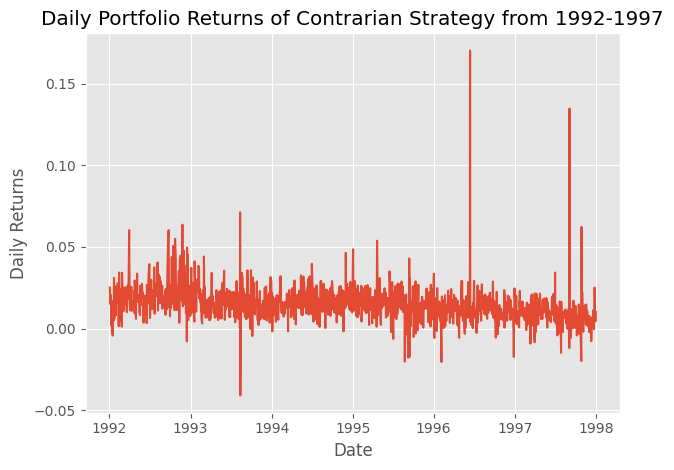

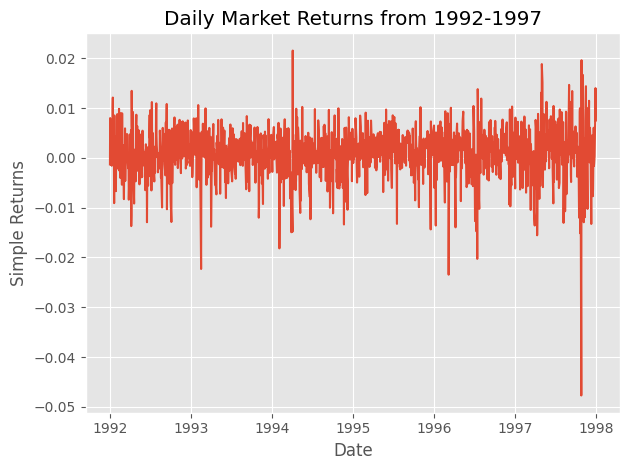

   mean_ann   vol_ann     sharpe
k                               
1  3.724668  0.174427  21.353769
2  0.283507  0.118817   2.386068
3  0.165506  0.123786   1.337033
4  0.120330  0.109460   1.099306
5  0.055100  0.115171   0.478420


In [19]:
#Running Contrarian Strategy from K = 1-5

results = []

#SECTION 1A and 1B: Contrarian Strategy with Stats for K = 1
profit_1 = contrarian_strategy(run_return_df, run_excess_df, k = 1)

#Comparing distributions of strategy and market
strat_mean = profit_1.mean() * 252
strat_vol = profit_1.std() * np.sqrt(252)
strat_sharpe = strat_mean / strat_vol

mkt_mean = run_mean_df.mean() * 252
mkt_vol = run_mean_df.std() * np.sqrt(252)
mkt_sharpe = mkt_mean / mkt_vol

results.append({"k": 1, "mean_ann": strat_mean, "vol_ann": strat_vol, "sharpe": strat_sharpe})

print(f'Strategy Results: Annualized Mean: {strat_mean}, Annualized Vol: {strat_vol}, Sharpe Ratio: {strat_sharpe}')
print(f'Market Results: Annualized Mean: {mkt_mean}, Annualized Vol: {mkt_vol}, Sharpe Ratio: {mkt_sharpe}')

#Daily Portfolio Returns
plt.style.use("ggplot")
plt.figure()
plt.plot(profit_1.index, profit_1.values)
plt.title("Daily Portfolio Returns of Contrarian Strategy from 1992-1997")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.tight_layout()
plt.show()

#Daily Market Returns
plt.figure()
plt.plot(run_mean_df.index, run_mean_df.values)
plt.title("Daily Market Returns from 1992-1997")
plt.xlabel("Date")
plt.ylabel("Simple Returns")
plt.tight_layout()
plt.show()

#SECTION 2A: Contrarian Strategy with Stats for K = 1-5
for k in range(2, 6):
    profit_k = contrarian_strategy(run_return_df, run_excess_df, k)

    strat_mean = profit_k.mean() * 252
    strat_vol = profit_k.std() * np.sqrt(252)
    strat_sharpe = strat_mean / strat_vol

    mkt_mean = run_mean_df.mean() * 252
    mkt_vol = run_mean_df.std() * np.sqrt(252)
    mkt_sharpe = mkt_mean / mkt_vol

    results.append({"k": k, "mean_ann": strat_mean, "vol_ann": strat_vol, "sharpe": strat_sharpe})

strategy_df = pd.DataFrame(results).set_index("k")
print(strategy_df)

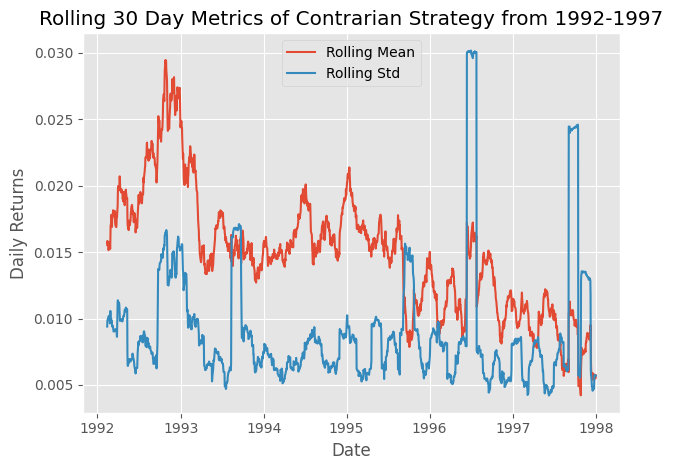

In [20]:
#SECTION ONE PARTS C-I: Further Analysis

#Part C
rolling_prof = profit_1.rolling(30).mean().dropna()
rolling_std = profit_1.rolling(30).std().dropna()

plt.figure()
plt.plot(rolling_prof.index, rolling_prof.values, label='Rolling Mean')
plt.plot(rolling_std.index, rolling_std.values, label='Rolling Std')
plt.title("Rolling 30 Day Metrics of Contrarian Strategy from 1992-1997")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
#Part D - looking an unusual events to try to explain outliers
best_days = profit_1.nlargest(10)
# print(best_days)
worst_days = profit_1.nsmallest(10)
# print(worst_days)

#Assuming normal IID, find all 3-sigma days
z = (profit_1 - profit_1.mean()) / profit_1.std()
unusual_days = profit_1[abs(z) > 3]
print(unusual_days.sort_values())

# Create a new DF without the unusual days
clean_profit = profit_1.drop(unusual_days.index)

strat_mean = profit_1.mean() * 252
strat_vol = profit_1.std() * np.sqrt(252)
strat_sharpe = strat_mean / strat_vol

clean_mean = clean_profit.mean() * 252
clean_vol = clean_profit.std() * np.sqrt(252)
clean_sharpe = clean_mean / clean_vol

print(f"Original: Mean: {strat_mean}, Vol: {strat_vol}, Sharpe: {strat_sharpe}")
print(f"Cleaned: Mean: {clean_mean}, Vol: {clean_vol}, Sharpe: {clean_sharpe}")

#TODO: Find what stocks are driving the top 2 best days in particular (6/13/1996, 9/4/1997)


d
1993-08-13   -0.041034
1996-02-05   -0.020569
1995-08-24   -0.020308
1997-10-27   -0.019949
1995-01-03    0.048540
1992-09-21    0.049323
1992-12-16    0.049608
1992-10-16    0.050778
1995-04-21    0.053799
1992-10-23    0.054943
1992-09-23    0.056998
1992-09-22    0.057941
1992-03-30    0.060250
1992-09-24    0.060276
1997-10-28    0.062230
1992-11-25    0.063606
1993-08-12    0.071174
1997-09-04    0.134792
1996-06-13    0.170289
dtype: float64
Original: Mean: 3.7246682385335554, Vol: 0.1744267343905063, Sharpe: 21.353769257611475
Cleaned: Mean: 3.6133277859770385, Vol: 0.1383929090533658, Sharpe: 26.109197434268115


In [22]:
#Part E
correlation = profit_1.corr(run_mean_df.loc[profit_1.index])
print(correlation) #Correlation small, seems market-neutral as well as dollar-neutral (by construction)

0.03921792084695984


In [23]:
#Part F
auto_correlation = profit_1.corr(profit_1.shift(1).loc[profit_1.index])
print(auto_correlation)

0.1982365086387864


In [24]:
#Part G
cumulative = (1 + profit_1).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min() 
print(max_drawdown)

-0.04997638352777327


In [25]:
#Part H
long_profit_1, short_profit_1 = contrarian_strategy(run_return_df, run_excess_df, k = 1, separate_ls=True)
ls_corr = long_profit_1.corr(short_profit_1)
print(ls_corr)

-0.27353108642366164


In [ ]:
#SECTION TWO PART B: Creating flat file for upload

In [ ]:
#SECTION THREE: Creating new strategy
def anti_revert_strategy(return_df, excess_df, k, separate_ls = False):
    '''
        Takes dataframes of simple and excess returns and a lag variable k and constructs a contrarian strategy with weights
            based on the negative excess returns k days ago.
        Returns a dataframe of strategy profits per day
    '''
    weight_df = (excess_df.shift(k - 1)).fillna(0)
    if separate_ls:
        long_weights, short_weights = normalize_weights(weight_df, separate_ls=separate_ls)

        #Find daily portfolio returns
        weight_1_lag = (long_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        long_profit = profit.iloc[k:]

        #Find daily portfolio returns
        weight_1_lag = (short_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        short_profit = profit.iloc[k:]
        return long_profit, short_profit
    else:
        norm_weight_df = normalize_weights(weight_df, separate_ls=separate_ls)

        #Data checks - ensure dates and columns are the same
        assert norm_weight_df.index.equals(return_df.index)
        assert norm_weight_df.columns.equals(return_df.columns)

        #Find daily portfolio returns
        weight_1_lag = (norm_weight_df.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        profit = profit.iloc[k:]
        return profit
    
def trend_strategy(return_df, excess_df, k, separate_ls = False):
    '''
        Takes dataframes of simple and excess returns and a lag variable k and constructs a contrarian strategy with weights
            based on the negative excess returns k days ago.
        Returns a dataframe of strategy profits per day
    '''
    # Form weights based on cumulative excess return over past J days
    cumulative_excess = excess_df.rolling(k).sum()
    weight_df = cumulative_excess.shift(1).fillna(0)  # buy winners, sell losers
    if separate_ls:
        long_weights, short_weights = normalize_weights(weight_df, separate_ls=separate_ls)

        #Find daily portfolio returns
        weight_1_lag = (long_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        long_profit = profit.iloc[k:]

        #Find daily portfolio returns
        weight_1_lag = (short_weights.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        short_profit = profit.iloc[k:]
        return long_profit, short_profit
    else:
        norm_weight_df = normalize_weights(weight_df, separate_ls=separate_ls)

        #Data checks - ensure dates and columns are the same
        assert norm_weight_df.index.equals(return_df.index)
        assert norm_weight_df.columns.equals(return_df.columns)

        #Find daily portfolio returns
        weight_1_lag = (norm_weight_df.shift(1)).fillna(0)
        profit = (weight_1_lag * return_df).sum(axis = 1)
        profit = profit.iloc[k:]
        return profit
    


Strategy Results: Annualized Mean: -0.002788557497016469, Annualized Vol: 0.1075554150727427, Sharpe Ratio: -0.02592670480728925
Market Results: Annualized Mean: 0.2276194396538298, Annualized Vol: 0.07799526840017582, Sharpe Ratio: 2.9183749773892274


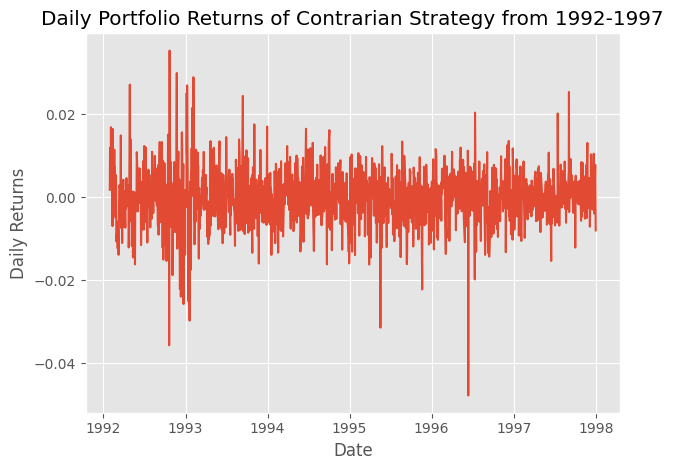

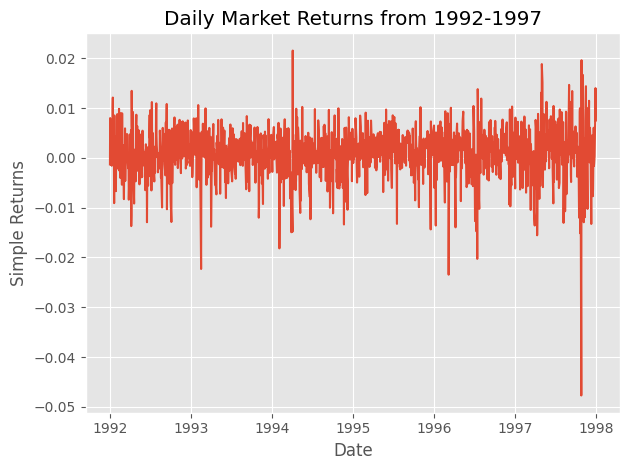

    mean_ann   vol_ann    sharpe
k                               
20 -0.002789  0.107555 -0.025927
40 -0.013840  0.097120 -0.142500
60 -0.011634  0.096163 -0.120982
80  0.029158  0.097679  0.298504


In [30]:
#Running Contrarian Strategy from K = 1-5

results = []

#SECTION 1A and 1B: Contrarian Strategy with Stats for K = 1
profit_1 = trend_strategy(run_return_df, run_excess_df, k = 20)

#Comparing distributions of strategy and market
strat_mean = profit_1.mean() * 252
strat_vol = profit_1.std() * np.sqrt(252)
strat_sharpe = strat_mean / strat_vol

mkt_mean = run_mean_df.mean() * 252
mkt_vol = run_mean_df.std() * np.sqrt(252)
mkt_sharpe = mkt_mean / mkt_vol

results.append({"k": 20, "mean_ann": strat_mean, "vol_ann": strat_vol, "sharpe": strat_sharpe})

print(f'Strategy Results: Annualized Mean: {strat_mean}, Annualized Vol: {strat_vol}, Sharpe Ratio: {strat_sharpe}')
print(f'Market Results: Annualized Mean: {mkt_mean}, Annualized Vol: {mkt_vol}, Sharpe Ratio: {mkt_sharpe}')

#Daily Portfolio Returns
plt.style.use("ggplot")
plt.figure()
plt.plot(profit_1.index, profit_1.values)
plt.title("Daily Portfolio Returns of Contrarian Strategy from 1992-1997")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.tight_layout()
plt.show()

#Daily Market Returns
plt.figure()
plt.plot(run_mean_df.index, run_mean_df.values)
plt.title("Daily Market Returns from 1992-1997")
plt.xlabel("Date")
plt.ylabel("Simple Returns")
plt.tight_layout()
plt.show()

#SECTION 2A: Contrarian Strategy with Stats for K = 1-5
for k in range(40, 100, 20):
    profit_k = trend_strategy(run_return_df, run_excess_df, k)

    strat_mean = profit_k.mean() * 252
    strat_vol = profit_k.std() * np.sqrt(252)
    strat_sharpe = strat_mean / strat_vol

    mkt_mean = run_mean_df.mean() * 252
    mkt_vol = run_mean_df.std() * np.sqrt(252)
    mkt_sharpe = mkt_mean / mkt_vol

    results.append({"k": k, "mean_ann": strat_mean, "vol_ann": strat_vol, "sharpe": strat_sharpe})

strategy_df = pd.DataFrame(results).set_index("k")
print(strategy_df)